# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import scipy
import functools
import menpo.io as mio

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from pathlib import Path
from menpo.image import Image
from menpo.shape import PointCloud
from menpo.transform import Scale

import deepmachine as dm

from deepmachine import contrib
from deepmachine import utils
from deepmachine import record_builder
from deepmachine.networks import graph


ge = tf.contrib.graph_editor
slim = tf.contrib.slim

# This is needed to display the images.
%matplotlib inline

D:\Anaconda2\envs\gitdev\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


## Env setup

In [2]:
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("../../models")
sys.path.append("../../models/object_detection/")


## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [11]:
# What model to download.
MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('../../models/object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [12]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [13]:
with tf.Graph().as_default() as detection_graph:
    obj_detector = dm.DeepMachine(
        functools.partial(
            graph.TFGraph,
            graph_def_path=PATH_TO_CKPT,
            input_tensor='image_tensor',
            output_tensors=['detection_boxes','detection_scores','detection_classes','num_detections'],
            is_training=False
        )
    )

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [14]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Detection

In [15]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = Path('./static/images/')
TEST_IMAGE_PATHS = list(PATH_TO_TEST_IMAGES_DIR.glob('*.jpg'))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [16]:
TEST_IMAGE_PATHS

[WindowsPath('static/images/image1.jpg'),
 WindowsPath('static/images/image2.jpg'),
 WindowsPath('static/images/image3.jpg'),
 WindowsPath('static/images/image4.jpg')]

static\images\image3.jpg


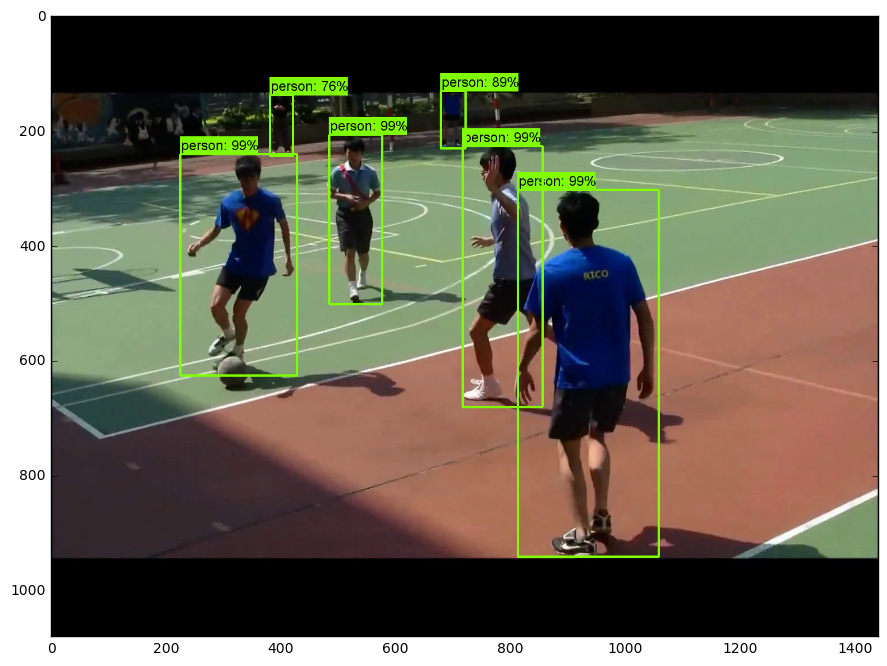

In [17]:
target_index = 2
for image_path in TEST_IMAGE_PATHS[target_index:target_index+1]:
    print(image_path)
    image = mio.import_image(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = (image.pixels_with_channels_at_back() * 255.).astype(np.uint8)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    boxes, scores, classes, num_detections = obj_detector.run_one(image_np_expanded, dtype=tf.uint8)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=4,
        min_score_thresh=0.5)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

### localisation

In [20]:
# model_path = '/homes/yz4009/db/ckpt_all/Pose/ckpt/inception_hourglass_pose/model.ckpt-56023'
model_path = 'D:/pretrained_models/model.ckpt-574050'
dense_pose_net = contrib.get_dense_pose_net_old()
dense_pose_net.restore_path = model_path

INFO:tensorflow:Restoring parameters from D:/pretrained_models/model.ckpt-574050


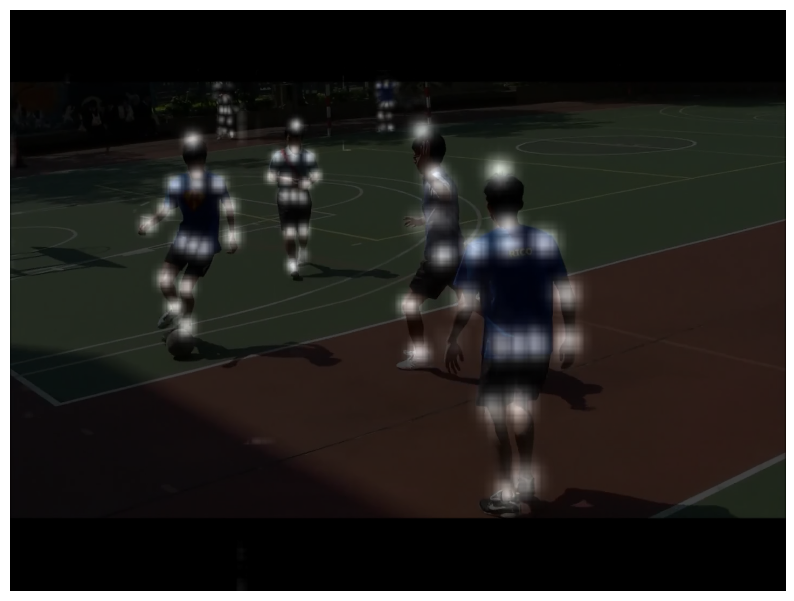

In [21]:
person_bbox = boxes[classes==1]
person_scores = scores[classes==1]

detection_bbox = [box for box, s in zip(person_bbox,person_scores) if s > 0.5]


overlay = []
for bbox in detection_bbox[::-1]:
    pts = bbox.reshape((-1,2)) * np.array([image.height, image.width])

    bbox = PointCloud(pts).bounding_box()

    cimg, trans, scale = utils.crop_image_bounding_box(image, bbox, [256,256], base=256)

    lms_hm_prediction, states = dense_pose_net.run_one(
        cimg.pixels_with_channels_at_back().astype(np.float32)[None, ...],
        data_eps={'heatmap':np.random.sample([1, 256, 256, 16])}
    )
#     iuv = states['uv']

    bsize,h,w,n_ch = lms_hm_prediction.shape
    lms_hm_prediction_filter = np.stack(list(map(
                                lambda x: scipy.ndimage.filters.gaussian_filter(*x),
                                zip(lms_hm_prediction.transpose(0,3,1,2).reshape(-1,h,w), [5] * (bsize * n_ch)))))

    hs = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 2), 1)
    ws = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 1), 1)
    pts_predictions = np.stack([hs,ws]).T
    
#     iuv_img = Image.init_from_channels_at_back(utils.convert.iuv_rgb(iuv,'hsv'))
    heatmap_img = Image.init_from_channels_at_back(lms_hm_prediction[0].squeeze().max(axis=-1))
    
#     overlay.append(iuv_img.warp_to_shape(image.shape, trans.pseudoinverse()).pixels)
    overlay.append(heatmap_img.warp_to_shape(image.shape, trans.pseudoinverse()).pixels)
    
image.view()
overlay = np.array(overlay).max(axis=0)
Image(overlay).view(alpha=0.75)

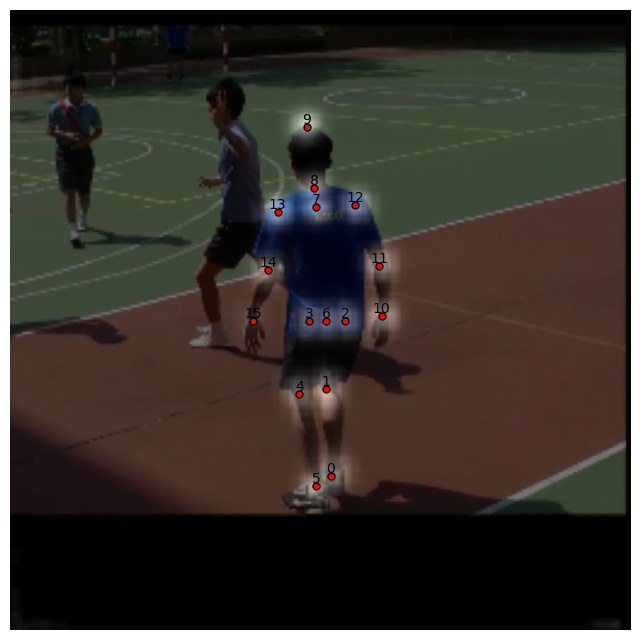

In [22]:
cimg.view()
PointCloud(pts_predictions).view(render_numbering=True)
Image.init_from_channels_at_back(lms_hm_prediction[0].squeeze().max(axis=-1)).view(alpha=0.55)


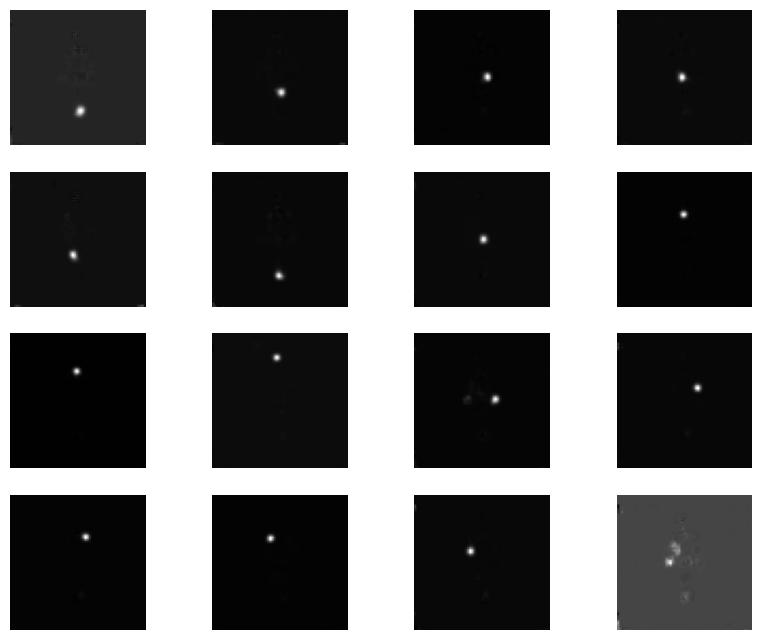

In [23]:
Image.init_from_channels_at_back(lms_hm_prediction[0].squeeze()).view()

In [15]:
raise Exception('stop here')

Exception: stop here

### Test

In [ ]:
data_it = utils.tf_records_iterator('/vol/atlas/databases/tf_records_pose/posetrack_val.tfrecords')

In [ ]:
data = data_it.__next__()

In [ ]:
with tf.Session() as sess:
    image_test = sess.run(dm.data_provider.base.image_resolver({
        'image': data['image'].bytes_list.value[0],
        'width': data['width'].int64_list.value[0],
        'height': data['height'].int64_list.value[0]
    }))

In [ ]:
image_test = Image.init_from_channels_at_back(image_test)

In [ ]:
lms_hm_prediction, states = dense_pose_net.run_one(image_test.pixels_with_channels_at_back()[None, ...])

In [ ]:
bsize,h,w,n_ch = lms_hm_prediction.shape
lms_hm_prediction_filter = np.stack(list(map(
                            lambda x: scipy.ndimage.filters.gaussian_filter(*x),
                            zip(lms_hm_prediction.transpose(0,3,1,2).reshape(-1,h,w), [5] * (bsize * n_ch)))))

hs = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 2), 1)
ws = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 1), 1)
pts_predictions = np.stack([hs,ws]).T

In [ ]:
Image(lms_hm_prediction_filter).view()

In [ ]:
image_test.view()
Image(lms_hm_prediction_filter.mean(axis=0)).view(alpha=0.8)
PointCloud(pts_predictions).view(render_numbering=True)

In [ ]:
def tf_image_patch_around_lms(image, lms, patch_size=32):

    pad_size = patch_size // 2 + 1
    lms = lms + tf.constant([pad_size, pad_size])
    image = tf.pad(image, [[pad_size,pad_size],[pad_size,pad_size],[0, 0]])
    
    def crop(x):
        return tf.image.crop_to_bounding_box(image, x[0] - pad_size, x[1] - pad_size, patch_size, patch_size)
    
    image = tf.concat(tf.unstack(tf.map_fn(crop, lms, dtype=tf.float32)), axis=-1)

    return image

In [ ]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        tfimage = tf.constant(image_test.pixels_with_channels_at_back()[None,...], dtype=tf.float32)
        tflms = tf.constant(pts_predictions[None,...], dtype=tf.int32)
        
        batch_size = tf.shape(tflms)[0]
        
        patch_img = sess.run(
            tf.map_fn(
                lambda x: tf_image_patch_around_lms(tfimage[x], tflms[x]), 
                tf.range(batch_size),
                dtype=tf.float32
            )
        )

In [ ]:
patch_img.shape

In [ ]:
Image.init_from_channels_at_back(patch_img).view()